# Ham or spam SMS with KAN

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from kan import *
from kan.utils import ex_round

#read 1st row modified database of SMS

data0 = pd.read_csv('/home/sam/Documents/spam.csv',encoding = "ISO-8859-1",dtype=str)
#original database at https://archive.ics.uci.edu/dataset/228/sms+spam+collection

/home/sam/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data0.head()

,label,SMS,s1,s2,s3
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
#getting rid of the nan values, labeling spam as 1 and ham as 0 and adding acolumn for SMS text length

data0.dropna(axis='columns',inplace=True) 
data0["label1"]=data0["label"].map({'spam': 1.0, 'ham': -1.0})
data0["Text_size"]=data0["SMS"].str.len()
data0.head()

,label,SMS,label1,Text_size
0,ham,"Go until jurong point, crazy.. Available only ...",-1.0,111
1,ham,Ok lar... Joking wif u oni...,-1.0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1.0,155
3,ham,U dun say so early hor... U c already then say...,-1.0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",-1.0,61


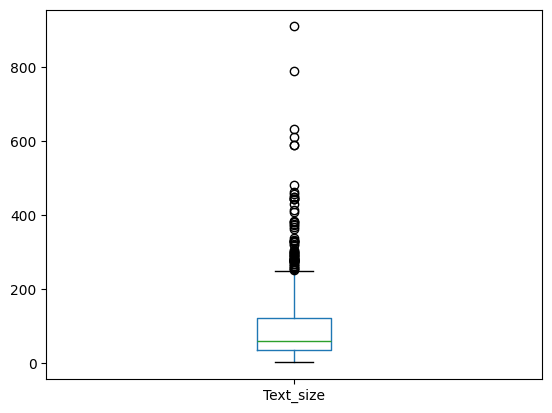

In [4]:
#detect outliers with boxplot
data0.boxplot(column="Text_size",grid=False)
plt.show()

Percentage of values with text size greater than 250: 0.01%
Number of values with text size greater than 250: 68


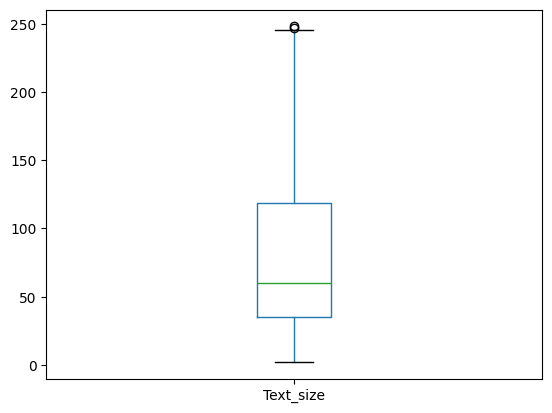

In [5]:
#create new database for input with text size less than 250
data1=data0[data0["Text_size"]<=250]
print('Percentage of values with text size greater than 250: '+str(round(len(data0[data0["Text_size"]>250])/len(data0),2))+'%')
print('Number of values with text size greater than 250: '+str(len(data0[data0["Text_size"]>250])))
data1.boxplot(column="Text_size",grid=False)
plt.show()

In [6]:
#Using transformers library to tokenize the text

padtkn=max(data1.Text_size) #padding number to have all tensors of the same length
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
encodedinp=tokenizer(data1.SMS.tolist(),padding=True,truncation=True,max_length=padtkn,return_tensors='pt')

In [7]:
#creating database for the KAN model to read with sklearn 

x=encodedinp['input_ids']
x=torch.tensor(x,dtype=torch.float32)
y=data1.label1.tolist()
y=torch.tensor(y,dtype=torch.float32).reshape(len(y),1)

xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size =.1, random_state = 42)
data={'train_input':xtrain,'test_input':xtest,'train_label':ytrain,'test_label':ytest}
print(xtrain[0])
print('Size of each input vector: '+str(len(xtrain[0])))
print('Size of train data: '+str(len(xtrain)))
print('Size of test data: '+str(len(xtest)))

tensor([ 101., 4403., 1177., 1184., 1116., 1103., 2197., 1142., 2068.,  136.,
         102.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.])
Size of each input vector: 114
Size of train data: 4953
Size of test data: 551


/tmp/ipykernel_4156/797478831.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float32)


In [34]:
# creating the KAN model input size: 114, number of hidden neurons: 40, 
# 4th degree spline since higher polynomials "flatten" better at 0 and grid of 25 since higher polynomials may require more grid points

model = KAN(width=[114,40,1], grid=25, k=4, seed=42)

checkpoint directory created: ./model
saving model version 0.0


In [35]:
#check model initial accuracy

y0 = model(xtest)
accuracy = (y0.round() == ytest).float().mean()
print(y0[:5])
print(f'Accuracy: {accuracy}')

tensor([[406.5481],
        [ 81.3487],
        [ 65.8792],
        [  4.3321],
        [-62.0319]], grad_fn=<SliceBackward0>)
Accuracy: 0.0018148820381611586


In [36]:
#fit model 25 steps and learning rate .01

loss1=model.fit(data, opt="LBFGS", steps=25, lamb=0.01)

| train_loss: 5.72e-01 | test_loss: 9.43e-01 | reg: 1.73e+02 | : 100%|█| 25/25 [13:22<00:00, 32.11s/

saving model version 0.1


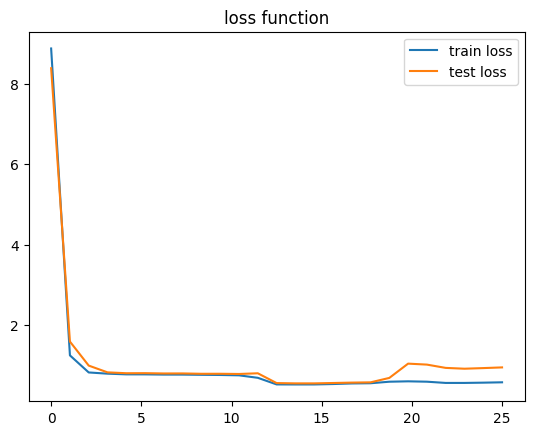

In [37]:
# plotting the loss function
x = np.linspace(0, 25, 25)
plt.plot(x,loss1['train_loss'],label='train loss')
plt.plot(x,loss1['test_loss'],label='test loss')
plt.title('loss function')
plt.legend()
plt.show()

In [38]:
#verify values of the output after training the model

y0=model(xtest)
print(y0[:15])
print(ytest[:15])

tensor([[ 0.0507],
        [-0.8863],
        [-1.5232],
        [-1.3296],
        [-0.9726],
        [-1.2915],
        [-1.1308],
        [-1.2843],
        [-1.2898],
        [ 0.5459],
        [-0.5536],
        [-1.4880],
        [-1.2479],
        [-0.3972],
        [-0.5923]], grad_fn=<SliceBackward0>)
tensor([[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]])


In [39]:
# As we can see from the predicted outputs y0, unlike sigmoid, KAN does not flatten that easily at 1 
# so we create function out10 to create a threshold for spam

def out10(data,thres=.7):
    n=len(data)
    for i in range(n):
        if data[i][0]>=thres:
            data[i][0]=1.0
        else:
            data[i][0]=-1.0
    return(data)

#verify accuracy of test input for different threshold
for i in range(-5,10):
    threshold = i/10
    yn=out10(model(xtest),threshold)
    accuracy = (yn == ytest).float().mean()
    print(f'Accuracy: {accuracy}, threshold: {threshold}')

Accuracy: 0.8765880465507507, threshold: -0.5
Accuracy: 0.9001814723014832, threshold: -0.4
Accuracy: 0.9201452136039734, threshold: -0.3
Accuracy: 0.9201452136039734, threshold: -0.2
Accuracy: 0.9237749576568604, threshold: -0.1
Accuracy: 0.9219600558280945, threshold: 0.0
Accuracy: 0.9092559218406677, threshold: 0.1
Accuracy: 0.905626118183136, threshold: 0.2
Accuracy: 0.8929219841957092, threshold: 0.3
Accuracy: 0.8892921805381775, threshold: 0.4
Accuracy: 0.8911070823669434, threshold: 0.5
Accuracy: 0.8856624364852905, threshold: 0.6
Accuracy: 0.8820326924324036, threshold: 0.7
Accuracy: 0.8784028887748718, threshold: 0.8
Accuracy: 0.8747731447219849, threshold: 0.9


In [30]:
# we create a new model with a 8 degree polynomial

model8 = KAN(width=[114,40,1], grid=20, k=8, seed=42)

checkpoint directory created: ./model
saving model version 0.0


In [32]:
loss8 = model8.fit(data, opt="LBFGS", steps=20, lamb=0.01)

| train_loss: 2.57e-01 | test_loss: 2.71e-01 | reg: 2.28e+02 | : 100%|█| 20/20 [13:13<00:00, 39.66s/

saving model version 0.1


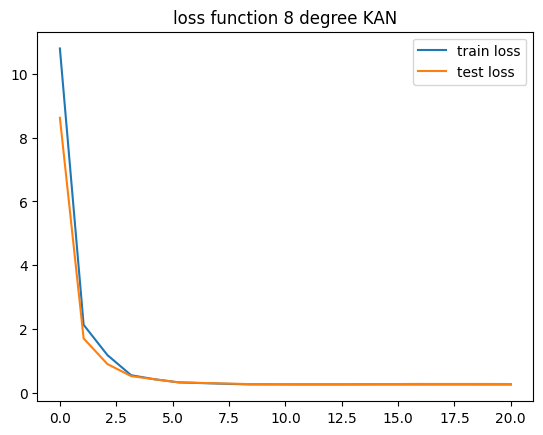

In [34]:
# plotting the loss function
x = np.linspace(0, 20, 20)
plt.plot(x,loss8['train_loss'],label='train loss')
plt.plot(x,loss8['test_loss'],label='test loss')
plt.title('loss function 8 degree KAN')
plt.legend()
plt.show()

In [36]:
#verify values of the output after training the 8 degree model

y8 = model8(xtest)
print(y8[:15])
print(ytest[:15])

tensor([[ 0.5288],
        [-0.0287],
        [ 0.0006],
        [ 0.0608],
        [ 0.0438],
        [ 0.0825],
        [-0.0072],
        [ 0.0884],
        [ 0.0246],
        [ 0.4019],
        [ 0.3205],
        [ 0.0532],
        [ 0.1533],
        [ 0.3329],
        [ 0.0648]], grad_fn=<SliceBackward0>)
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [37]:
def out10(data,thres=.7):
    n=len(data)
    for i in range(n):
        if data[i][0]>=thres:
            data[i][0]=1.0
        else:
            data[i][0]=0.0
    return(data)

#verify accuracy of test input for different threshold
for i in range(1,10):
    threshold = i/10
    yn=out10(model8(xtest),threshold)
    accuracy = (yn == ytest).float().mean()
    print(f'Accuracy: {accuracy}, threshold: {threshold}')

Accuracy: 0.7350271940231323, threshold: 0.1
Accuracy: 0.840290367603302, threshold: 0.2
Accuracy: 0.8929219841957092, threshold: 0.3
Accuracy: 0.9183303117752075, threshold: 0.4
Accuracy: 0.9128856658935547, threshold: 0.5
Accuracy: 0.8856624364852905, threshold: 0.6
Accuracy: 0.872958242893219, threshold: 0.7
Accuracy: 0.8675135970115662, threshold: 0.8
Accuracy: 0.8656987547874451, threshold: 0.9


In [41]:
model2 = KAN(width=[114,40,1], grid=5, k=2, seed=42)

checkpoint directory created: ./model
saving model version 0.0


In [42]:
loss2 = model2.fit(data, opt="LBFGS", steps=15, lamb=0.001)

| train_loss: 2.72e-01 | test_loss: 2.80e-01 | reg: 2.26e+02 | : 100%|█| 15/15 [03:13<00:00, 12.91s/

saving model version 0.1


In [43]:
#verify values of the output after training the model

y2=model2(xtest)
print(y2[:15])
print(ytest[:15])

tensor([[ 0.3768],
        [ 0.2265],
        [-0.0024],
        [-0.0535],
        [ 0.1306],
        [ 0.1191],
        [ 0.0132],
        [ 0.1008],
        [ 0.0242],
        [ 0.7872],
        [ 0.6262],
        [ 0.0929],
        [ 0.1332],
        [ 0.2475],
        [ 0.0815]], grad_fn=<SliceBackward0>)
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [44]:
def out10(data,thres=.7):
    n=len(data)
    for i in range(n):
        if data[i][0]>=thres:
            data[i][0]=1.0
        else:
            data[i][0]=0.0
    return(data)

#verify accuracy of test input for different threshold
for i in range(1,10):
    threshold = i/10
    yn=out10(model2(xtest),threshold)
    accuracy = (yn == ytest).float().mean()
    print(f'Accuracy: {accuracy}, threshold: {threshold}')

Accuracy: 0.680580735206604, threshold: 0.1
Accuracy: 0.8312159776687622, threshold: 0.2
Accuracy: 0.8947368264198303, threshold: 0.3
Accuracy: 0.905626118183136, threshold: 0.4
Accuracy: 0.9001814723014832, threshold: 0.5
Accuracy: 0.8911070823669434, threshold: 0.6
Accuracy: 0.8838475346565247, threshold: 0.7
Accuracy: 0.8711434006690979, threshold: 0.8
Accuracy: 0.8675135970115662, threshold: 0.9
